In [1]:
import pandas as pd
from difflib import SequenceMatcher
import seaborn as sns
# plotting
%matplotlib widget
from matplotlib import pyplot as plt

import data_utilities as du

## Climate Targets Dataset
#### Bethany Schoen, 14th June 2024

Data was taken from Climate Policy Radar's public database on governmental climate policies.

With a large amount of content available, searching through these files can be a difficult task for users. Therefore, I questioned whether policies could be grouped into clusters based on their content in order to create additional metadata. Labelled content can support the usability of the platform by providing users with:
- a wider range of filters when searching for documents,
- recommendations for similar documents once they have finished reading a selected file. 

**This notebook explores:**
 - Hashing Experimentation
 - Text Preprocessing and Data Transformation
 - Clustering and Group Analysis


---

#### Hashing Experimentation

My original idea was to use some form of hashing that could represent original document structure in a more condensed format in order to find similar files.

Here's an example I experimented with looking at how the edit distance between strings could be used to cluster words:

In [2]:
df = pd.DataFrame([
    ["Catastrophe", 0],
    ["Apostrophe", 0],
    ["Choreograph", 0],
    ["Cryptograph", 0],
    ["Elephant", 1],
    ["Relevant", 1],
    ["Elegant", 1],
    ["Binocular", 2],
    ["Particular", 2],
    ["Molecular", 2]
], columns=["Word", "Group"])

df = du.hash_text_data_using_ssdeep(df, "Word")

df

,Word,Group,Hashed
0,Catastrophe,0,3:3ONA:yA
1,Apostrophe,0,3:cNUS:cNZ
2,Choreograph,0,3:2qnn:2Cn
3,Cryptograph,0,3:ZVRKXN:ZOd
4,Elephant,1,3:Mr:Mr
5,Relevant,1,3:8A2:8A2
6,Elegant,1,3:Myn:Myn
7,Binocular,2,3:gQJEX:gc+
8,Particular,2,3:c9:u
9,Molecular,2,3:Xr:7


For such small words, the hash strings are too disimilar. Therefore, I continued looking at the edit distance of the original words:

In [3]:
# create a matrix analysing the similarities between words
for row in df.itertuples():
    first_word = row.Word
    df[first_word] = 0.0
    for i, second_word in enumerate(list(df.Word)):
        df.at[i, first_word] = SequenceMatcher(None, first_word, second_word).ratio()
df

,Word,Group,Hashed,Catastrophe,Apostrophe,Choreograph,Cryptograph,Elephant,Relevant,Elegant,Binocular,Particular,Molecular
0,Catastrophe,0,3:3ONA:yA,1.000000,0.666667,0.363636,0.454545,0.210526,0.105263,0.111111,0.100000,0.190476,0.200000
1,Apostrophe,0,3:cNUS:cNZ,0.666667,1.000000,0.476190,0.380952,0.222222,0.111111,0.117647,0.210526,0.100000,0.210526
2,Choreograph,0,3:2qnn:2Cn,0.363636,0.476190,1.000000,0.727273,0.315789,0.210526,0.333333,0.200000,0.095238,0.300000
3,Cryptograph,0,3:ZVRKXN:ZOd,0.363636,0.476190,0.727273,1.000000,0.210526,0.105263,0.222222,0.200000,0.095238,0.200000
4,Elephant,1,3:Mr:Mr,0.210526,0.222222,0.315789,0.210526,1.000000,0.625000,0.800000,0.117647,0.222222,0.352941
5,Relevant,1,3:8A2:8A2,0.210526,0.111111,0.210526,0.105263,0.625000,1.000000,0.666667,0.117647,0.222222,0.352941
6,Elegant,1,3:Myn:Myn,0.222222,0.117647,0.333333,0.111111,0.800000,0.666667,1.000000,0.125000,0.235294,0.375000
7,Binocular,2,3:gQJEX:gc+,0.200000,0.210526,0.200000,0.100000,0.235294,0.235294,0.250000,1.000000,0.631579,0.666667
8,Particular,2,3:c9:u,0.380952,0.200000,0.190476,0.285714,0.222222,0.222222,0.235294,0.631579,1.000000,0.526316
9,Molecular,2,3:Xr:7,0.200000,0.210526,0.200000,0.100000,0.352941,0.352941,0.375000,0.666667,0.526316,1.000000


<Axes: >

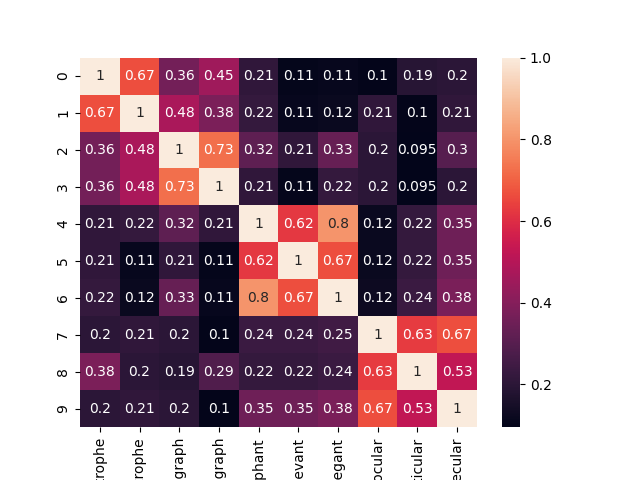

In [4]:
heatmap_data = df.iloc[:, -10:]
sns.heatmap(heatmap_data, annot=True)

This heatmap could help determine an edit-distance threshold defining which words can be considered similar. Three clusters of words are identifiable in the plot. This suggests a technique comparing the edit distance between hash strings may be an option for clustering data points. 

---

#### Text Preprocessing & Data Transformation

Importing real data:

In [5]:
df = du.read_parquet_data(filename='national-climate-targets.parquet', filepath='input-data')

df.head()

,ID,text,annotation_agent,geography,region,translated,annotation_NZT,annotation_Reduction,annotation_Other
0,0,"Meanwhile, in September 2015, the Republic of ...",0,AZE,Europe & Central Asia,False,0,0,0
1,1,Indicators Economic development (1) Gross dome...,1,CHN,East Asia & Pacific,True,0,0,0
2,2,ENERGY AND TRAI\nContinued support to energy e...,1,HRV,Europe & Central Asia,False,0,0,0
3,3,INDONESIA LONG-TERM STRATEGY 17 FOR LOW CARBON...,1,IDN,East Asia & Pacific,False,0,0,0
4,4,Mitigation Measure Manitoba Energy Efficiency ...,1,CAN,North America,True,0,1,1


In [6]:
print(f"Number of documents available: {len(df)}")

Number of documents available: 2610


I quickly realised that designing a heatmap comparing the similarities between 2610 documents would be inefficient and ineffective. Furthermore, I questioned whether the order of the document was as important as the content itself. Therefore, my strategy changed to focus on more traditional techniques for data representation - Bag of Words to identify patterns in text using word/ngram frequency. 

Before creating a document-term matrix (DTM), I pre-processed text to filter redundant information. This will help the ML model to focus on the most important features and reduce the dimensionality of the DTM. 

In [7]:
df_preprocessed = du.pre_process_text_col_in_data(df, "text")

df_preprocessed[["text", "text_preprocessed"]].head()

,text,text_preprocessed
0,"Meanwhile, in September 2015, the Republic of ...",september 2015 republic azerbaijan join sustai...
1,Indicators Economic development (1) Gross dome...,indicators economic development 1 gross domest...
2,ENERGY AND TRAI\nContinued support to energy e...,energy trai continue support energy efficiency...
3,INDONESIA LONG-TERM STRATEGY 17 FOR LOW CARBON...,indonesia longterm strategy 17 low carbon clim...
4,Mitigation Measure Manitoba Energy Efficiency ...,mitigation measure manitoba energy efficiency ...


In [8]:
df_preprocessed.to_csv(r"intermediary-data\df_preprocessed.csv", index=False)

The DTM was created using Sci-kit Learn's Count Vectorizor. This meant only the frequency of words within documents was considered in the analysis. I analysed ngrams of length 3 as after having an initial read of the data, it appeared several important terms in documents could be made up of several words.

In [9]:
X_bow = du.create_document_term_matrix(df_preprocessed, "text_preprocessed", ngram=3)
X_bow = X_bow.fillna(0)

X_bow.head()

,10 renewable energy,10 share biofuel,10 share energy,10 share renewable,100 gwh year,100 percent carbon,100 renewable energy,1000 gwh year,1200 anonperson heat,14th fiveyear plan,...,year activity plan,year base year,year energy long,year reference period,year reference value,year renewable energy,year represent reduction,zero emission 2050,zero emission vehicle,zero greenhouse gas
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


To visualise this new structured representation of our corpus, I used Truncated SVD to reduce dimensionality to a visualisable number of dimenions. 

In [10]:
X_bow_3d = du.reduce_dtm_using_svd(X_bow, 3)

X_bow_3d.head()

,0,1,2
0,0.003360,0.001622,0.035187
1,0.003081,0.002475,0.012505
2,0.003651,0.001941,0.110625
3,0.003387,0.002068,0.006635
4,0.003372,-0.000110,0.002077


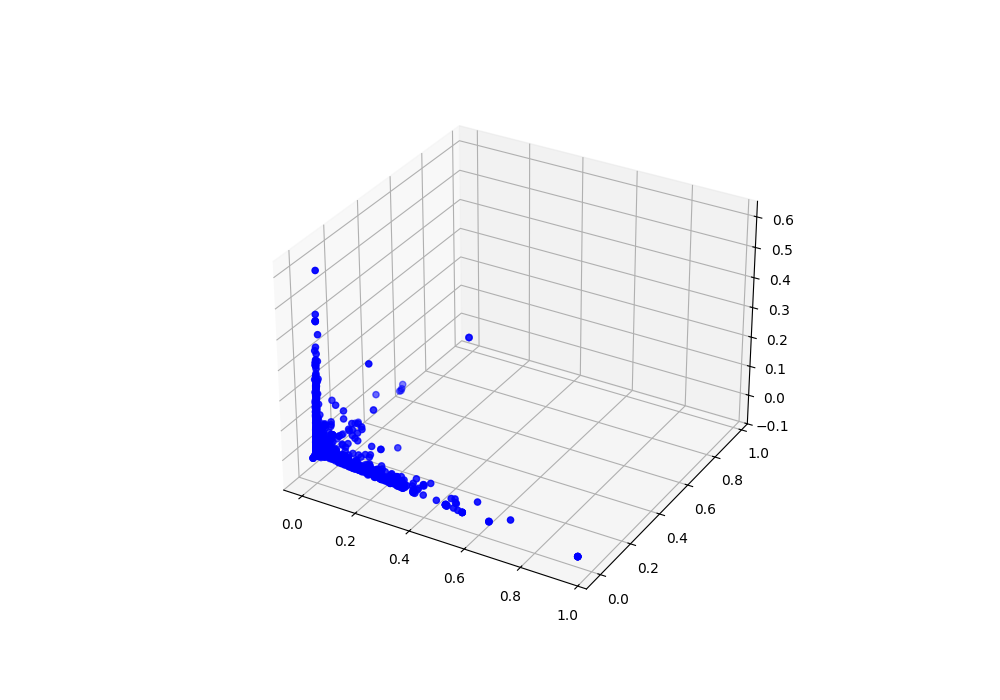

In [11]:
du.plot_3d_data(X_bow_3d, 0, 1, 2)

Interestingly, the transformed data points appear to fall on two (maybe three) orthoganol axes within a 3D space. This could be an indication towards groupings in the data existing.  

---

## Clustering and Group Analysis
Condensing information to three dimensions is quite a rapid reduction in dimensionality. Therefore, before clustering data, I re-performed the dimensionality reduction step, reducing to 10 dimensions. 

In [12]:
X_bow_100d = du.reduce_dtm_using_svd(X_bow, 10)

I used the k-means algorithm to cluster documents as it an explainable, easy-to-use algorithm. Given the appearence of two axes in the above plot, I chose to start with 2 clusters in this analysis. 

In [13]:
results = du.cluster_documents_using_kmeans(X_bow_100d, 2)


Attempt 0
Number of elements assigned to each cluster: [2399  211]
Silhouette Score: 0.6515503443107938

Attempt 1
Number of elements assigned to each cluster: [ 211 2399]
Silhouette Score: 0.6515503443107938

Attempt 2
Number of elements assigned to each cluster: [ 211 2399]
Silhouette Score: 0.6515503443107938

Attempt 3
Number of elements assigned to each cluster: [ 211 2399]
Silhouette Score: 0.6515503443107938

Attempt 4
Number of elements assigned to each cluster: [2399  211]
Silhouette Score: 0.6515503443107938


With each iteration, very similar amounts within each cluster are being identified. The silhouette score can fall between -1 and 1. With a score around 0.65, the definitions of our clusters could be better, but for a first attempt, are not bad.

In [14]:
results.head()

,0,1,2,3,4,5,6,7,8,9,label
0,0.003360,0.006314,0.033303,-0.000413,0.001227,-0.000167,0.004253,0.011156,0.005552,-0.007619,0
1,0.003082,0.003601,0.010279,-0.000641,0.000729,0.000615,0.000414,0.000875,0.009224,0.005263,0
2,0.003651,0.017820,0.108225,-0.016636,-0.007208,0.002463,-0.024049,-0.037657,-0.007289,0.006317,0
3,0.003387,0.002097,0.005086,0.004448,0.013043,-0.003020,-0.011513,0.009583,0.001820,-0.002666,0
4,0.003372,0.001441,0.000680,0.001430,0.003798,-0.000607,-0.004393,0.003255,0.000204,0.001486,0


Having assigned a label to each document, I repeated the plotting of points but this time coloured them based on their assignment. 

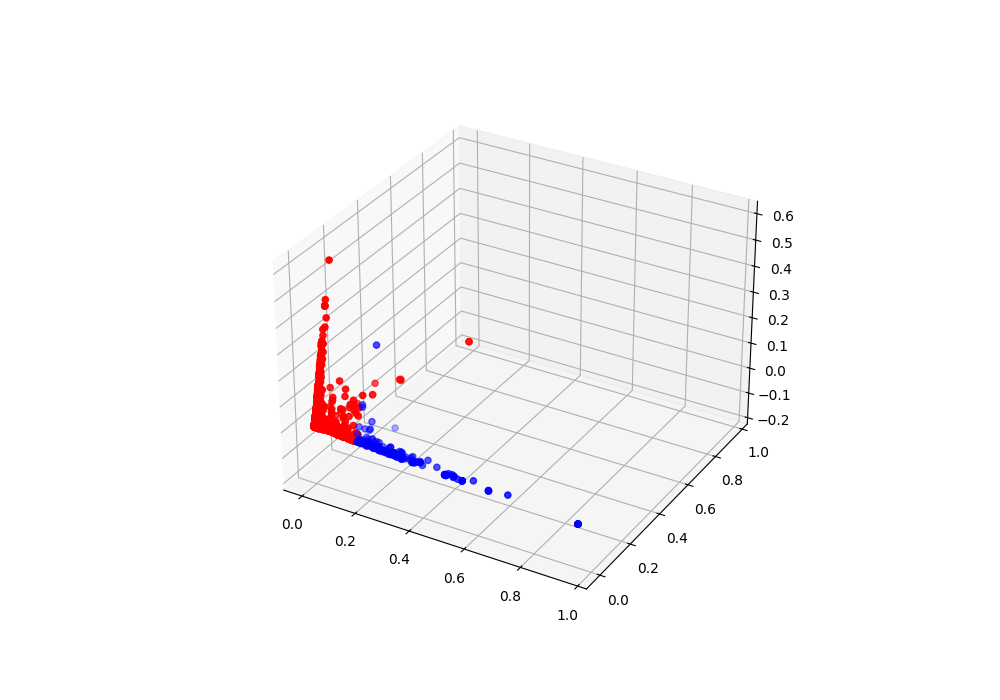

In [15]:
X_results_3d = du.reduce_dtm_using_svd(results[[0, 1, 2]], 3)
results_3d = pd.concat([X_results_3d, results["label"]], axis=1)

fig = plt.figure(figsize=(10, 7))

group0 = results_3d[results_3d.label == 0]
group1 = results_3d[results_3d.label == 1]

ax1 = fig.add_subplot(projection='3d')
ax1.scatter(group0[0], group0[1], group0[2], color='r')
ax1.scatter(group1[0], group1[1], group1[2], color='b')

plt.show()

In 3D, it appears a decision boundary has been created, dividing points around x=0.17.

Next, I analysed the frequency of terms within each group to understand how the data has been partitioned:

In [16]:
docs_and_labels = pd.concat([df_preprocessed[["text_preprocessed"]], results["label"]], axis=1)
docs_and_labels.to_csv(r"processed-data\docs_and_labels.csv", index=False)

docs_and_labels

,text_preprocessed,label
0,september 2015 republic azerbaijan join sustai...,0
1,indicators economic development 1 gross domest...,0
2,energy trai continue support energy efficiency...,0
3,indonesia longterm strategy 17 low carbon clim...,0
4,mitigation measure manitoba energy efficiency ...,0
...,...,...
2605,reduce environmental pollution combat climate ...,0
2606,task forces emission expert responsible work p...,0
2607,2020 solar energy importance intermittent 1990...,0
2608,planning sector methodological assumptions app...,0


In [17]:
group0_bow_df_transposed = du.analyse_terms_in_each_cluster(
    docs_and_labels[docs_and_labels.label == 0], "text_preprocessed", ngram=3)

group0_bow_df_transposed.head(20)

,Count,Percent
renewable energy source,237,0.127488
greenhouse gas emission,212,0.114040
final energy consumption,166,0.089295
share renewable energy,141,0.075847
reduce ghg emission,134,0.072082
energy renewable source,97,0.052179
use renewable energy,77,0.041420
improve energy efficiency,76,0.040882
reduce greenhouse gas,74,0.039806
nationally determined contribution,73,0.039268


In [18]:
group1_bow_df_transposed = du.analyse_terms_in_each_cluster(
    docs_and_labels[docs_and_labels.label == 1], "text_preprocessed", ngram=3)

group1_bow_df_transposed.head(20)

,Count,Percent
greenhouse gas emission,400,0.523560
reduce greenhouse gas,113,0.147906
reduction greenhouse gas,61,0.079843
total greenhouse gas,18,0.023560
gas emission reduction,18,0.023560
emission reduction target,16,0.020942
compare 1990 level,15,0.019634
carbon dioxide equivalent,12,0.015707
gas emission energy,12,0.015707
ton carbon dioxide,11,0.014398


Looking at the frequency of 3-grams in each group, group 0 may be focusing on a variety of topics, but group 1 seems to have more focus on greenhouse gases and emissions. This suggests this clustering activity may have found a sensible subset within our corpus. 

Check there are no outlying documents skewing the frequency of terms:

In [19]:
# create new column counting the amount of times "greenhouse gas emission" appears in a document
search_str = "greenhouse gas emission"
docs_and_labels["ghe_count"] = docs_and_labels.apply(lambda row: row.text_preprocessed.count(search_str), axis=1)

docs_and_labels[(docs_and_labels.label == 1)].sort_values(by="ghe_count", ascending=False)

,text_preprocessed,label,ghe_count
1011,biennial update report cte d39ivoire 2018 list...,1,10
814,target type absolute reduction greenhouse gas ...,1,7
1954,fulhiment surplus actual surplus accordance ac...,1,7
906,law republic kazakhstan 505iv december 3 2011 ...,1,6
101,chapter 421 carbon footprint 42ii economic pol...,1,6
...,...,...,...
1251,bangladesh take number initiative enhance good...,1,1
1277,6 management risk relate environmental protect...,1,1
1287,32 un framework convention climate change repo...,1,1
214,l public private person operate aerodrome defi...,1,0


Plot the results in a histogram to visualise distribution:

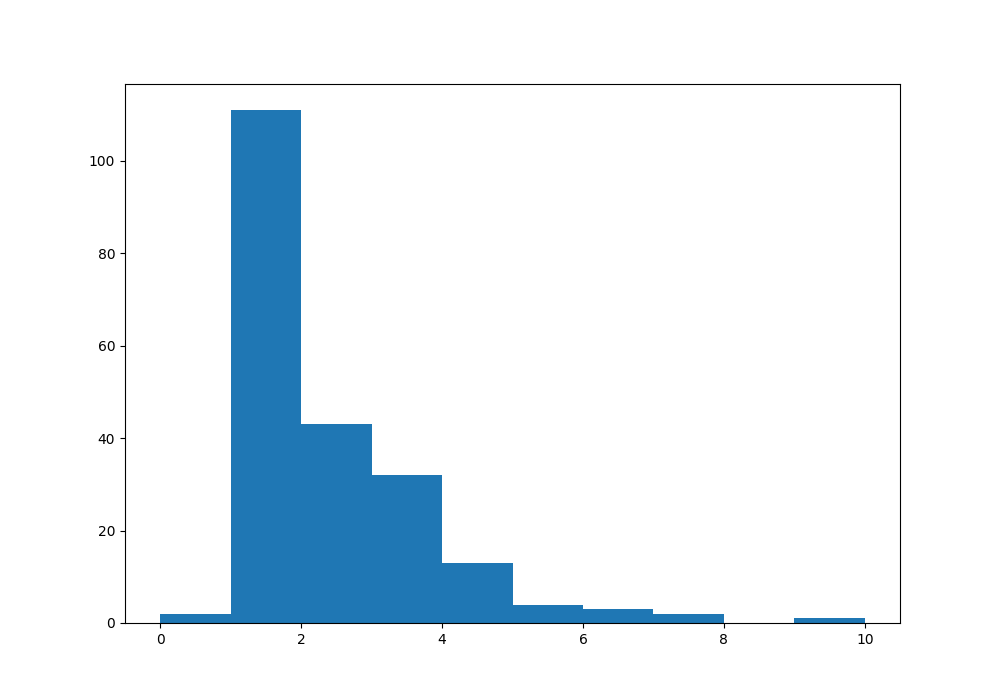

In [20]:
fig = plt.figure(figsize=(10, 7))

plt.hist(docs_and_labels[(docs_and_labels.label == 1)]["ghe_count"])

plt.show()

Given that "greenhouse gas emission" is mentioned 400 times in group 1, there is no single document that mentions this 3-gram an overwhelming amount of times. 

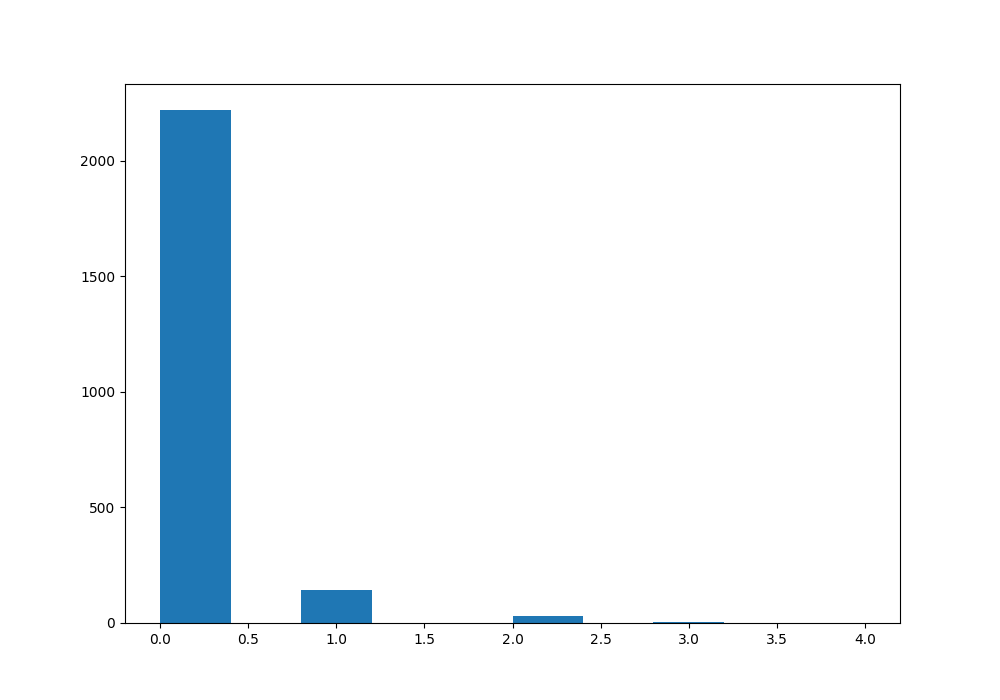

In [21]:
fig = plt.figure(figsize=(10, 7))

plt.hist(docs_and_labels[(docs_and_labels.label == 0)]["ghe_count"])

plt.show()

---
## Conclusion

Clustering algorithms could be used to automatically create topics in an otherwise unlabelled dataset to support users with navigating Climate Policy Radar's database. This simple example of its application identified a potential subset of just over 200 documents within the corpus focusing on greenhouse gas emissions. 

## Future Work
**There are several parts of this analysis that were not thoroughly explored and should be considered to help with the identification of reliable, representable group labels:**
- Number removal was initially not performed during text pre-processing as I wondered whether the year may be important. Next time, I could alter my code so that it only keeps 4-digit numbers.
- Various document representation methods exist that preserve the original structure or semantic meaning of the text. This may provide vital information necessary for defining clusters. 
- I chose 3-grams when constructing my DTM after a brief look over the data. More suitably-lengthed n-grams may be better for this problem. 
- I could experiement with the number of dimensions to reduce my feature set to before modelling. 
- Alternative clustering methods are available. If our groups of data are not spherical with points arranged around the prototypes, K-means may not be the most appropriate method. 
- Alternative distince metrics are available that may be more suited to text data e.g. cosine distance.
- The elbow method could be used for analysing how many clusters to create within the data.
- An analysis on which countries are more represented in which clusters may be beneficial for understanding the priorities of different states.
- In the final analysis, instead of looking at the frequency of 3-grams across the entire cluster, look at the most important 3-grams to each document and see how they compare to others in the same gorup.  
